# Import

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [94]:
df_sales_raw = pd.read_csv("train.csv", low_memory=False)
df_store_raw = pd.read_csv("store.csv", low_memory=False)

# Settings

In [95]:
plt.rcParams["figure.figsize"] = [9,6]
sns.set_theme()

# Data preparation

## Merge

In [96]:
df_raw = pd.merge(df_sales_raw, df_store_raw, on="Store", how="left")

## Data Types

In [97]:
df_raw["Date"] = df_raw["Date"].astype("datetime64")

# The other data types will be left to convert after we have dealt with NaN

## Excluding Columns and Rows

In [98]:
df_raw = df_raw[(df_raw["Open"] == 1) & (df_raw["Sales"] > 0)]

# Since we're using the model to predict sales, there's no way of knowing the number of customers in advance
df_raw = df_raw.drop(["Customers", "Open"], axis=1)

## Handling NaN

In [99]:
df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [100]:
max_distance = df_raw.CompetitionDistance.max()
print(max_distance)

75860.0


In [101]:
df_raw["CompetitionDistance"] = df_raw["CompetitionDistance"].fillna(max_distance)

In [102]:
df_raw["CompetitionOpenSinceMonth"] = df_raw.apply(lambda x: x["Date"].month if pd.isna(x["CompetitionOpenSinceMonth"]) else x["CompetitionOpenSinceMonth"], axis=1)

In [103]:
df_raw["CompetitionOpenSinceYear"] = df_raw.apply(lambda x: x["Date"].year if pd.isna(x["CompetitionOpenSinceYear"]) else x["CompetitionOpenSinceYear"], axis=1)

In [104]:
# When there's no promotion, we choose a random interval to try not to introduce biases to the data
df_raw["PromoInterval"] = df_raw["PromoInterval"].apply(lambda x: random.choice(['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']) if pd.isna(x) else x)

In [105]:
df_raw["Promo2SinceYear"] = df_raw.apply(lambda x: x["Date"].year if pd.isna(x["Promo2SinceYear"]) else x["Promo2SinceYear"], axis=1)

In [106]:
df_raw["Promo2SinceWeek"] = df_raw.apply(lambda x: x["Date"].week if pd.isna(x["Promo2SinceWeek"]) else x["Promo2SinceWeek"], axis=1)

In [107]:
df_raw["StateHoliday"] = df_raw["StateHoliday"].apply(lambda x: "public_holiday" if x=="a" else "easter" if x=="b" else "christmas" if x=="c" else "none")

In [108]:
df_raw["Assortment"] = df_raw["Assortment"].apply(lambda x: "basic" if x=="a" else "extra" if x=="b" else "extended")

In [109]:
# The rest of the type conversions
df_raw["CompetitionOpenSinceMonth"] = df_raw["CompetitionOpenSinceMonth"].astype(int)
df_raw["CompetitionOpenSinceYear"] = df_raw["CompetitionOpenSinceYear"].astype(int)
df_raw["Promo2SinceWeek"] = df_raw["Promo2SinceWeek"].astype(int)
df_raw["Promo2SinceYear"] = df_raw["Promo2SinceYear"].astype(int)

# Descriptive Statistics

In [110]:
df1 = df_raw.copy()
num_attributes = df1.select_dtypes(include=["int64", "float64"])

In [111]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
Store,558.421374,558.0,321.730861,1.0,1115.0,0.000426,-1.198836
DayOfWeek,3.520350,3.0,1.723712,1.0,7.0,0.019310,-1.259347
Sales,6955.959134,6369.0,3103.815515,46.0,41551.0,1.594929,4.854027
Promo,0.446356,0.0,0.497114,0.0,1.0,0.215824,-1.953425
SchoolHoliday,0.193578,0.0,0.395102,0.0,1.0,1.551109,0.405939
CompetitionDistance,5640.427743,2330.0,8580.824305,20.0,75860.0,3.603153,19.654695
CompetitionOpenSinceMonth,6.787355,7.0,3.309917,1.0,12.0,-0.048451,-1.231875
CompetitionOpenSinceYear,2010.331102,2012.0,5.502628,1900.0,2015.0,-7.217323,123.903078
Promo2,0.498670,0.0,0.499999,0.0,1.0,0.005320,-1.999976
Promo2SinceWeek,23.629083,22.0,14.288315,1.0,52.0,0.170399,-1.194815


[Text(0, 0, 'Basic'), Text(1, 0, 'Extra'), Text(2, 0, 'Extended')]

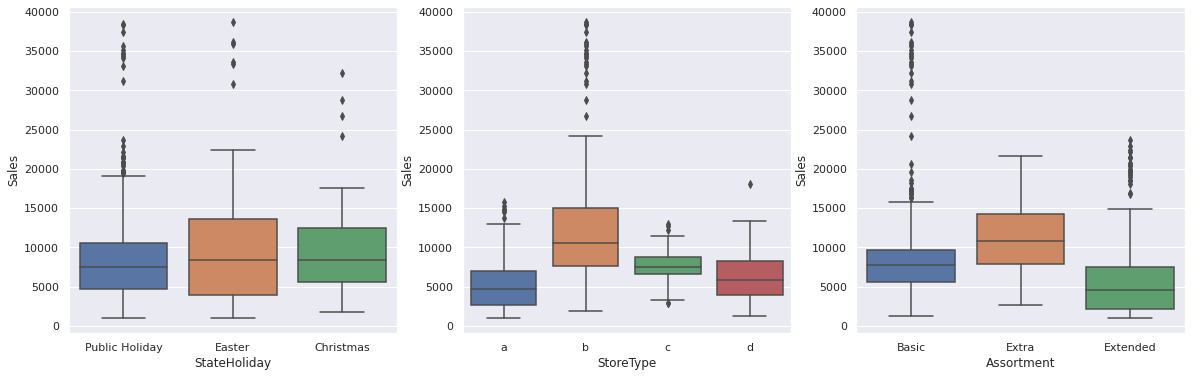

In [112]:
aux = df1[(df1["StateHoliday"] != "none") & (df1["Sales"] > 0)]
fig, ax = plt.subplots(figsize=(20,6))
ax1 = plt.subplot(1,3,1)
sns.boxplot(x="StateHoliday", y="Sales", data=aux, order=["public_holiday","easter","christmas"], ax=ax1)
ax1.set_xticklabels(["Public Holiday","Easter","Christmas"])
ax2 = plt.subplot(1,3,2)
sns.boxplot(x="StoreType", order=["a","b","c","d"], y="Sales", data=aux, ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(x="Assortment", y="Sales", order=["basic","extra","extended"], data=aux, ax=ax3)
ax3.set_xticklabels(["Basic", "Extra", "Extended"])

# Feature Engineering

## Hypotheses

1. Stores with closer competition sell less
3. Stores sell less on state holidays
4. Stores sell less on school holidays
5. Stores sell more as time goes on
6. Stores sell less on weekends
7. Stores that ran promotions for longer sell more
8. Stores sell less on the month before the promotion 2 resets

## Data Manipulation

In [113]:
df2 = df1.copy()

In [114]:
df2["CompetitionSince"] = df2.apply(lambda x: pd.Timestamp( year=x["CompetitionOpenSinceYear"], month=x["CompetitionOpenSinceMonth"], day=1), axis=1)
df2["CompetitionSinceMonths"] = (((df2["Date"] - df2["CompetitionSince"]).apply(lambda x: x.days))/30).astype(int)

In [115]:
df2["Promo2Since"] = (df2["Promo2SinceYear"].astype(str) + "-" + df2["Promo2SinceWeek"].astype(str) + "-1")
df2["Promo2Since"] = df2["Promo2Since"].apply(lambda x: datetime.datetime.strptime(x, "%G-%V-%u"))
df2["Promo2SinceWeeks"] = ((df2["Date"] - df2["Promo2Since"])/7).apply(lambda x: x.days).astype(int)

In [116]:
df2 = df2.drop(columns=["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear"])

In [117]:
df2.sample(5)

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,CompetitionSince,CompetitionSinceMonths,Promo2Since,Promo2SinceWeeks
423767,853,2,2014-06-17,12167,1,none,1,a,basic,14040.0,0,"Jan,Apr,Jul,Oct",2014-06-01,0,2014-06-16,0
455621,372,1,2014-05-19,11475,1,none,0,d,extended,4880.0,1,"Jan,Apr,Jul,Oct",2010-08-01,46,2014-04-28,3
690489,1090,1,2013-10-21,8856,1,none,1,a,basic,330.0,1,"Jan,Apr,Jul,Oct",2013-10-01,0,2011-04-04,133
491144,215,4,2014-04-17,8310,1,none,1,d,basic,150.0,1,"Feb,May,Aug,Nov",2014-04-01,0,2009-11-02,232
715602,558,6,2013-09-28,2487,0,none,0,a,basic,3000.0,0,"Jan,Apr,Jul,Oct",2010-02-01,44,2013-09-23,0


# Exploratory Analysis

In [118]:
df3 = df2.copy()

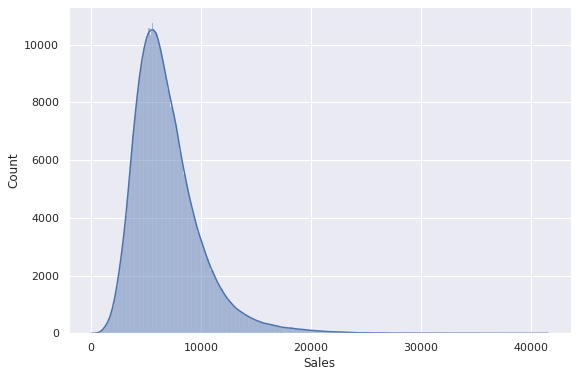

In [119]:
sns.histplot(df3["Sales"], kde=True);

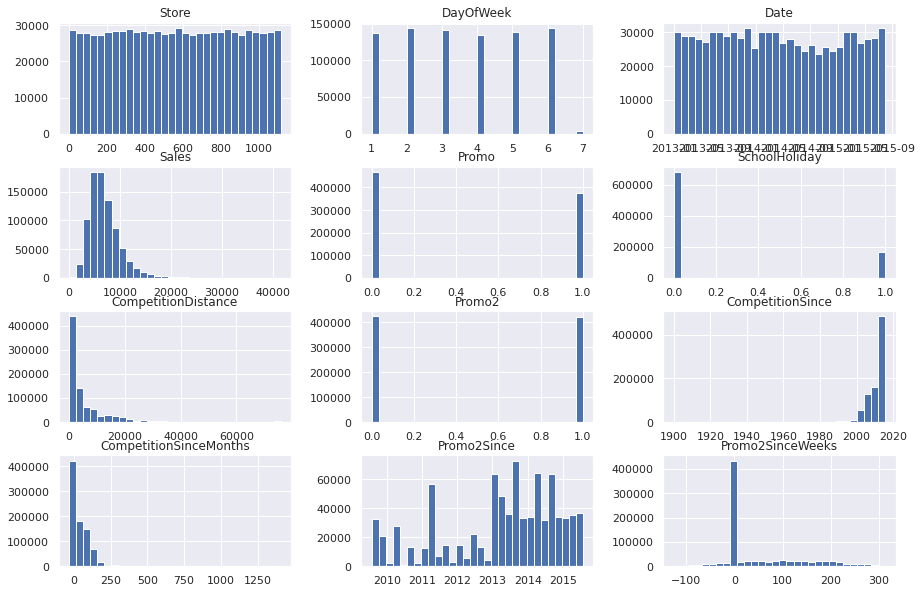

In [120]:
df3.hist(bins=30,figsize=(15,10));

<AxesSubplot:xlabel='Sales', ylabel='Density'>

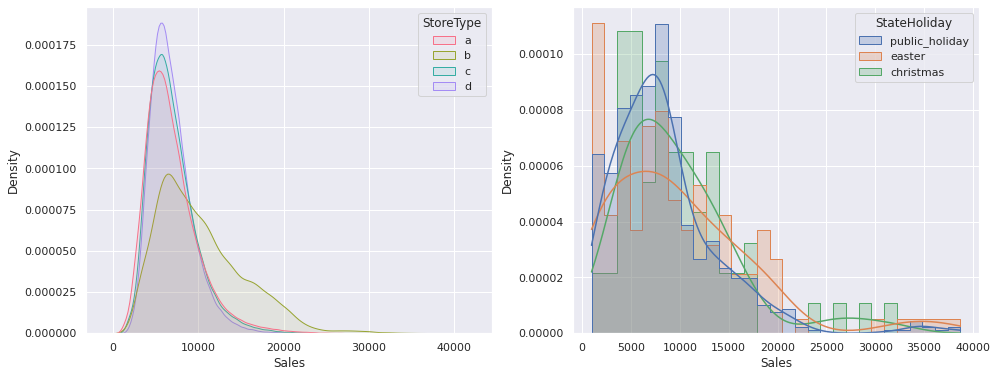

In [121]:
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.kdeplot(data=df3, x="Sales", hue="StoreType", hue_order=["a","b","c","d"], common_norm=False, fill=True, alpha=0.1, palette="husl")
plt.subplot(1,2,2)
sns.histplot(data=df3[df3["StateHoliday"]!="none"], x="Sales", hue="StateHoliday", element="step", stat="density", common_norm=False, kde=True)

## Hypothesis: Stores with closer competition sell less

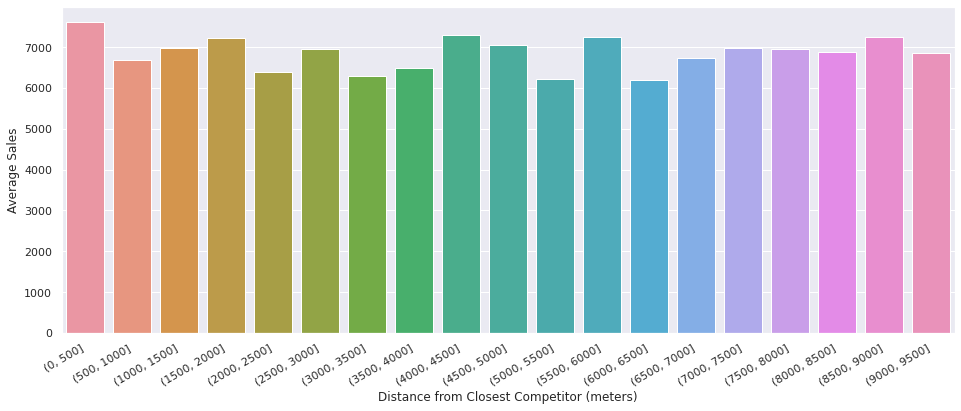

In [122]:
fig, ax = plt.subplots(figsize=(16,6))
aux = df3[["Sales", "CompetitionDistance"]].copy()
aux["DistanceBinned"] = pd.cut(aux["CompetitionDistance"], bins=range(0,10000,500))
aux2 = aux[["Sales", "DistanceBinned"]].groupby("DistanceBinned").mean().reset_index()
sns.barplot(x="DistanceBinned", y="Sales", data=aux2)
ax.set_xlabel("Distance from Closest Competitor (meters)")
ax.set_ylabel("Average Sales")
plt.xticks(rotation=30, horizontalalignment="right");

### Result: There's no significative relation between competition distance and sales

## Hypothesis: Stores that ran promotions for longer sell more

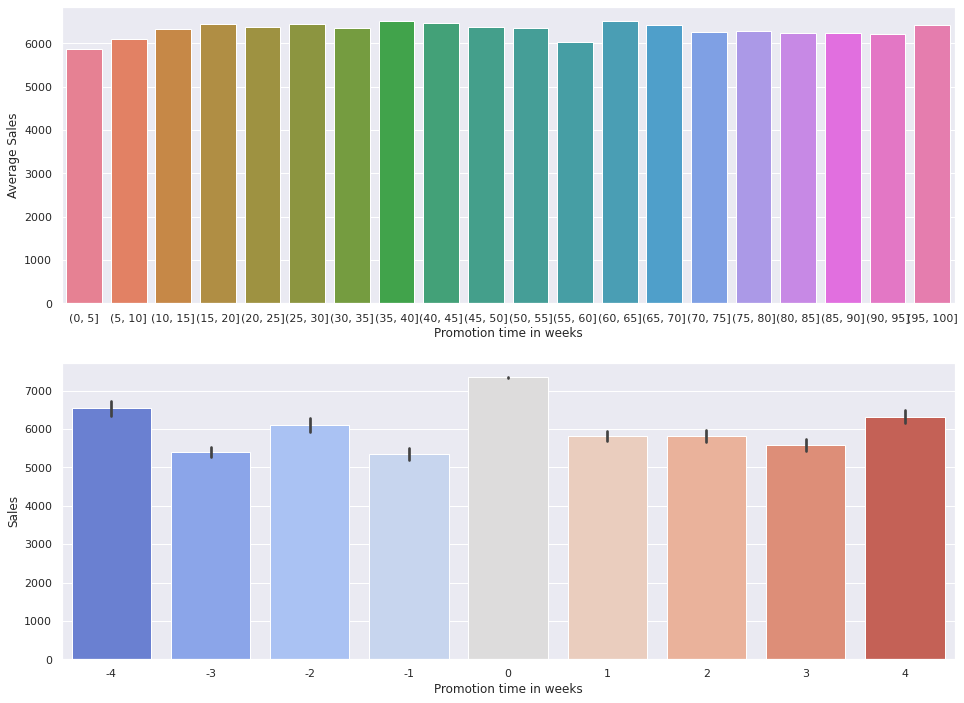

In [123]:
fig, ax = plt.subplots(figsize=(16,12))
aux = df3[["Sales", "Promo2SinceWeeks"]].copy()
aux["TimeBinned"] = pd.cut(aux["Promo2SinceWeeks"], bins=range(0,105,5))
aux2 = aux[["TimeBinned", "Sales"]].groupby("TimeBinned").mean().reset_index()
ax1 = plt.subplot(2,1,1)
sns.barplot(x="TimeBinned", y="Sales", data=aux2, palette="husl")
ax1.set_xlabel("Promotion time in weeks")
ax1.set_ylabel("Average Sales")
ax2 = plt.subplot(2,1,2)
sns.barplot(x="Promo2SinceWeeks", y="Sales", data=aux[(aux["Promo2SinceWeeks"]>-5) & (aux["Promo2SinceWeeks"]<5)], palette="coolwarm")
ax2.set_xlabel("Promotion time in weeks")
ax1.set_ylabel("Average Sales");

There doesn't seem to be a clear trend when looking at the combined data. We'll try looking at a small sample of stores.

In [124]:
random.seed(0)
stores_list = random.sample(list(df3.loc[df3["Promo2SinceWeeks"]<=-5,"Store"].unique()), k=5)
aux = df3.loc[df3["Store"].isin(stores_list), ["Store", "Promo2SinceWeeks", "Sales"]]
aux = aux.groupby(["Promo2SinceWeeks","Store"]).mean().reset_index()

(-20.0, 20.0)

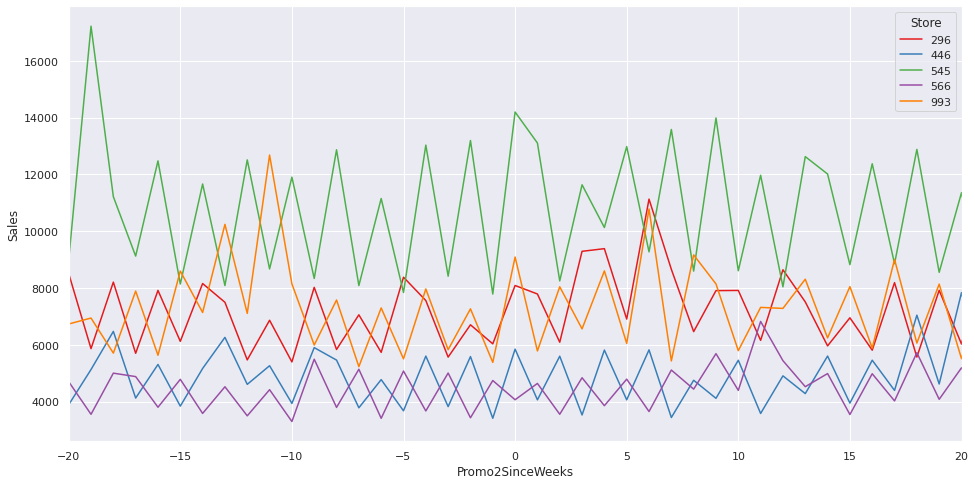

In [125]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x="Promo2SinceWeeks", y="Sales", data=aux, hue="Store", palette="Set1")
ax.set_xlim(-20,20)

We observe that even looking at individual stores there is no difference in behaviour before and after the promotion. Therefore:

### Result: There's no relation between the duration of the promotion 2 and sales

## Hypothesis: Stores sell less on the month before the promotion 2 resets

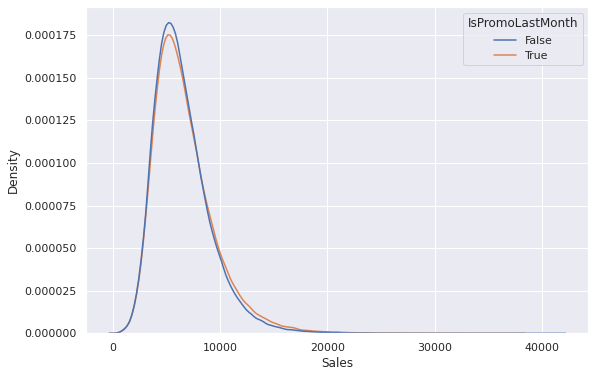

In [126]:
aux = df3.loc[df3["Promo2"]==1, ["Date", "Sales", "PromoInterval"]]
aux["IsPromoLastMonth"] = (aux["Date"].dt.month.isin([3,6,9,12])) & (aux["PromoInterval"] == "Jan,Apr,Jul,Oct")|\
                          (aux["Date"].dt.month.isin([1,4,7,10])) & (aux["PromoInterval"] == "Feb,May,Aug,Nov")|\
                          (aux["Date"].dt.month.isin([2,5,8,11])) & (aux["PromoInterval"] == "Mar,Jun,Sept,Dec")

sns.kdeplot(x="Sales", hue="IsPromoLastMonth", common_norm=False, data=aux);

### Result: Stores sell approximately the same on the month before the promotion 2 resets

## Hypothesis: Stores sell less on state holidays

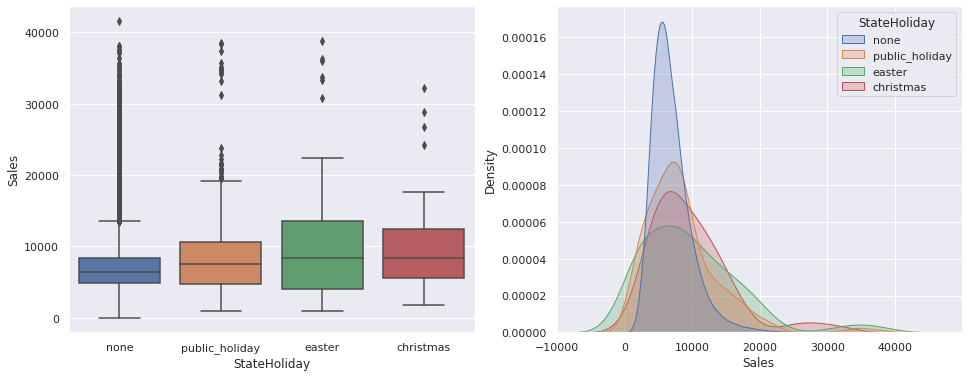

In [127]:
ax, fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(x="StateHoliday", y="Sales", data=df3)
plt.subplot(1,2,2)
sns.kdeplot(data=df3, x="Sales", hue="StateHoliday", common_norm=False, fill=True);

### Result: False, stores sell more on average on state holidays, but with greater variance than regular days

## Hypothesis: Stores sell less on school holidays

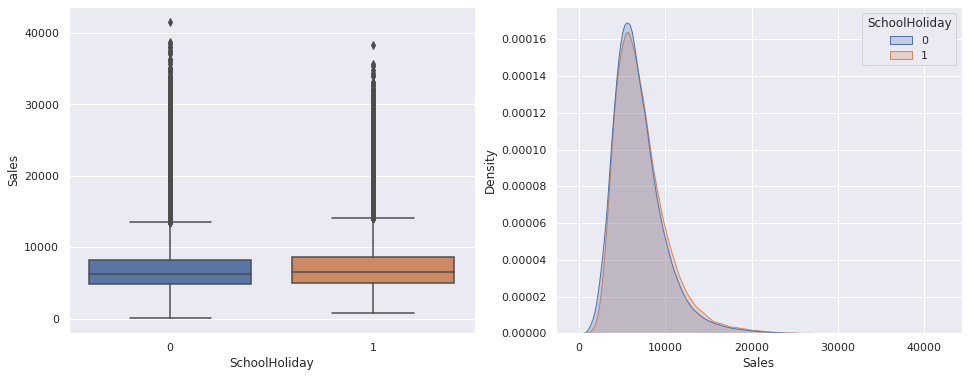

In [128]:
ax, fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(x="SchoolHoliday", y="Sales", data=df3)
plt.subplot(1,2,2)
sns.kdeplot(data=df3, x="Sales", hue="SchoolHoliday", common_norm=False, fill=True);

In [129]:
print(df3[df3["SchoolHoliday"]==1].Sales.mean())
print(df3[df3["SchoolHoliday"]==1].Sales.std() / len(df3[df3["SchoolHoliday"]==1]) ** 0.5 ) 

7200.710281746153
7.85542429861489


In [130]:
print(df3[df3["SchoolHoliday"]==0].Sales.mean())
print(df3[df3["SchoolHoliday"]==0].Sales.std() / len(df3[df3["SchoolHoliday"]==0]) ** 0.5 ) 

6897.20783001147
3.736711868888133


### Result: False, stores sell more on school holidays, but it's a very small difference

## Hypothesis: Stores sell less on weekends

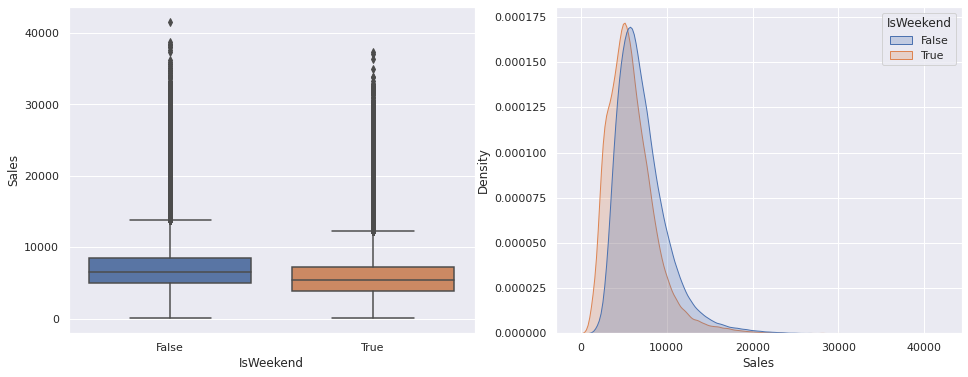

In [131]:
aux = df3[["Sales", "DayOfWeek"]].copy()
aux["IsWeekend"] = aux["DayOfWeek"].isin([6,7])
ax, fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(x="IsWeekend", y="Sales", data=aux)
plt.subplot(1,2,2)
sns.kdeplot(data=aux, x="Sales", hue="IsWeekend", common_norm=False, fill=True);

In [132]:
print(aux[aux["IsWeekend"]==True].Sales.mean())
print(aux[aux["IsWeekend"]==True].Sales.std() / len(aux[aux["IsWeekend"]==True]) ** 0.5 ) 

5932.264336753699
7.814378768957097


In [133]:
print(aux[aux["IsWeekend"]==False].Sales.mean())
print(aux[aux["IsWeekend"]==False].Sales.std() / len(aux[aux["IsWeekend"]==True]) ** 0.5 ) 

7172.903208443317
8.019524799643674


### Result: True, stores sell less on weekends

## Hypothesis: Stores sell more as time goes on

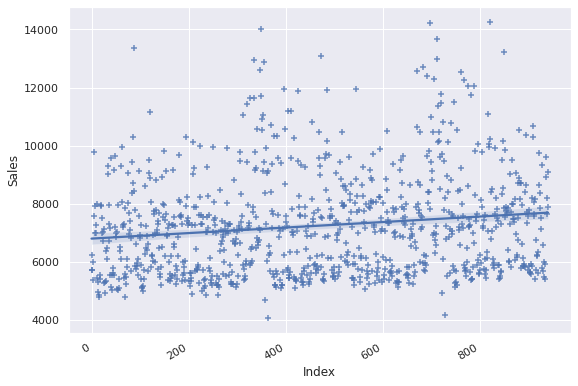

In [134]:
aux = df3[["Date", "Sales"]].groupby("Date").mean().reset_index()
#aux = aux.rolling(5, on="Date").mean()
aux["Index"] = aux.index

sns.regplot(x="Index", y="Sales", data=aux, marker="+")
plt.xticks(rotation=30, horizontalalignment="right");

### Result: True, stores tend to sell more over time

# Data Preparation

## Scaling

In [135]:
df4 = df3.copy()

In [136]:
rs = RobustScaler()
mms = MinMaxScaler()
df4["CompetitionDistance"] = rs.fit_transform(df4[["CompetitionDistance"]].values)
df4["CompetitionSinceMonths"] = rs.fit_transform(df4[["CompetitionSinceMonths"]].values)
df4["Promo2SinceWeeks"] = mms.fit_transform(df4[["Promo2SinceWeeks"]].values)

## Encoding

In [137]:
# TODO: StateHoliday, StoreType, Assortment

In [138]:
df4 = pd.get_dummies(df4, prefix=["StateHoliday"], columns=["StateHoliday"])

In [139]:
le = LabelEncoder()
df4["StoreType"] = le.fit_transform(df4["StoreType"])

In [140]:
df4["Assortment"] = df4["Assortment"].map({"basic":1, "extra":2, "extended":3})